# Fitting Saturation-based Simulation Data
In this notebook, we try to fit intensity data generated using a saturation based method. The mu_a for each of the maternal and fetal layer are based on a set oxygen saturation and HB concentration. The impact of all other pigments on mu_a are ignored. The goal for this experiment is to see if we can train a model to determine these hidden variables - the Hb conc. and the saturation just by looking at the intensity values!

# Instructions
I have the parameter search in one of the cells. Run eveerything above it to be able to run that cell.
If you don't want to search, ignore that cell and run everything above and below. 

# Issues
1. Only the mu_a's are changed, not any of the other properties! 
2. Fetal performance is not nearly as good as maternal. This could be due to the noise in the far ends of the plots. Maybe interpolation would help?
3. Fetal errors: Sat: ~3% Sat., Conc: ~1.9


# Notes
1. Using interpolated values seems to make the fitting more stable. Not better however.
2. Maternal is very good.
3. Fetal just estimates a mean!

# Things to Try
1. Fetal | Maternal = known

In [61]:
import json
from pathlib import Path
from torch.optim import Adam, SGD
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn import preprocessing
from inverse_modelling_tfo.model_training import (
    generate_data_loaders,
    config_based_normalization,
)
from inverse_modelling_tfo.data.intensity_interpolation import (
    interpolate_exp,
    get_interpolate_fit_params,
    exp_piecewise_affine,
)
from inverse_modelling_tfo.data.interpolation_function_zoo import *
from inverse_modelling_tfo.model_training import RandomSplit, ValidationMethod, HoldOneOut, CVSplit, CombineMethods
from inverse_modelling_tfo.model_training.custom_models import (
    SplitChannelCNN,
    PerceptronReLU,
    PerceptronBN,
    PerceptronDO,
    PerceptronBD,
    CNN1d,
)
from inverse_modelling_tfo.features.build_features import (
    FetalACFeatureBuilder,
    RowCombinationFeatureBuilder,
    TwoColumnOperationFeatureBuilder,
    FetalACbyDCFeatureBuilder,
    LogTransformFeatureBuilder,
    ConcatenateFeatureBuilder,
)
from inverse_modelling_tfo.features.data_transformations import (
    LongToWideIntensityTransformation,
    ToFittingParameterTransformation,
)
from inverse_modelling_tfo.visualization import generate_model_error_and_prediction
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
import torchinfo
from inverse_modelling_tfo.misc.misc_training import set_seed

# Set my GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [62]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Pre-save data

In [63]:
# file_name = 'logI2_by_I1'
file_name = 'logI2_by_I1'
# Load data
DATA_PATH = Path().resolve().parent / "data" / "processed_data" / f"{file_name}.pkl"
data = pd.read_pickle(DATA_PATH)

# Load Configs
CONFIG_PATH = Path().resolve().parent / "data" / "processed_data" / f"{file_name}.json"
with open(CONFIG_PATH, "r") as f:
    config = json.load(f)
labels = config["labels"]
features = config["features"]

# Cleanup
data.dropna(inplace=True)

# Build Features

## Fetal AC by DC Feature

In [64]:
# fb1 = FetalACbyDCFeatureBuilder('FconcCenters', 'perm', intensity_columns, labels, "max")
# feature_builder2 = TwoColumnOperationFeatureBuilder(x_columns1[len(x_columns1)//2:], x_columns1[:len(x_columns1)//2], "/", False, x_columns1, feature_builder1.get_label_names())

## Row Combination Spatial Intensity (or their Log)

In [65]:
# fixed_columns = ['Maternal Wall Thickness', "Maternal Hb Concentration", "Maternal Saturation", "Fetal Saturation", "FconcCenters"]
# fb3 = RowCombinationFeatureBuilder(intensity_columns, fixed_columns, ["Fetal Hb Concentration"], 'perm', 2)

## Fetal AC_wv1 by AC_wv2 Feature Builder

In [66]:
# fb5 = FetalACFeatureBuilder('FconcCenters', 'perm', '/', intensity_columns, labels)
# x_columns5 = fb5.get_feature_names()
# fb6 = TwoColumnOperationFeatureBuilder.from_chain(fb5, x_columns5[len(x_columns5)//2:], x_columns5[:len(x_columns5)//2], "/", False)

## Fitting Parameters

In [67]:
# fb0 = RowCombinationFeatureBuilder(fitting_param_transformer.get_feature_names(), fixed_columns, ["Fetal Hb Concentration"], 'perm', 2)
# x_columns0 = fb0.get_feature_names()
# # AC operation
# fb8 = TwoColumnOperationFeatureBuilder.from_chain(fb0, x_columns0[:len(x_columns0)//2], x_columns0[len(x_columns0)//2:], '*', True)
# fb9 = TwoColumnOperationFeatureBuilder.from_chain(fb0, x_columns0[:len(x_columns0)//2], x_columns0[len(x_columns0)//2:], '+', False)
# fb7 = ConcatenateFeatureBuilder([fb8, fb9])

# data1 = fb7(fitting_params)

## Combining Them Together

In [68]:
# data = fb1(data)
# Concat FBs
# fb_concat = ConcatenateFeatureBuilder([fb1, fb3, fb6])
# data2 = fb_concat(data)
# data.head()

In [69]:
# labels = fb1.get_label_names()
# labels = fb_concat.get_label_names()
# Merge Features + Modified intensity data
# data = pd.merge(data1, data2, on=labels, how='inner')

In [70]:
# Define the input & output parameters to the NN
# x_columns = fb_concat.get_feature_names() + fb7.get_feature_names()
# x_columns = fb_concat.get_feature_names()
# x_columns = fb7.get_feature_names()
# x_columns = fb1.get_feature_names()
# Pick a single feature for the y_columns
# y_columns = ["Fetal Saturation"]

# Setup Training Objective

In [71]:
y_columns = ["Fetal Saturation"]    # What to predict

x_columns = features  # What to use as input
print("X Columns", x_columns)

X Columns ['10_2.0_1_/_10_2.0_2', '15_2.0_1_/_15_2.0_2', '19_2.0_1_/_19_2.0_2', '24_2.0_1_/_24_2.0_2', '28_2.0_1_/_28_2.0_2', '33_2.0_1_/_33_2.0_2', '37_2.0_1_/_37_2.0_2', '41_2.0_1_/_41_2.0_2', '46_2.0_1_/_46_2.0_2', '50_2.0_1_/_50_2.0_2', '55_2.0_1_/_55_2.0_2', '59_2.0_1_/_59_2.0_2', '64_2.0_1_/_64_2.0_2', '68_2.0_1_/_68_2.0_2', '72_2.0_1_/_72_2.0_2', '77_2.0_1_/_77_2.0_2', '81_2.0_1_/_81_2.0_2', '86_2.0_1_/_86_2.0_2', '90_2.0_1_/_90_2.0_2', '94_2.0_1_/_94_2.0_2', '10_1.0_1_/_10_1.0_2', '15_1.0_1_/_15_1.0_2', '19_1.0_1_/_19_1.0_2', '24_1.0_1_/_24_1.0_2', '28_1.0_1_/_28_1.0_2', '33_1.0_1_/_33_1.0_2', '37_1.0_1_/_37_1.0_2', '41_1.0_1_/_41_1.0_2', '46_1.0_1_/_46_1.0_2', '50_1.0_1_/_50_1.0_2', '55_1.0_1_/_55_1.0_2', '59_1.0_1_/_59_1.0_2', '64_1.0_1_/_64_1.0_2', '68_1.0_1_/_68_1.0_2', '72_1.0_1_/_72_1.0_2', '77_1.0_1_/_77_1.0_2', '81_1.0_1_/_81_1.0_2', '86_1.0_1_/_86_1.0_2', '90_1.0_1_/_90_1.0_2', '94_1.0_1_/_94_1.0_2']


## Normalizing Features
x_columns will be the input features and y_columns are the target

In [72]:
## Scale y
y_scaler = preprocessing.StandardScaler()
data[y_columns] = y_scaler.fit_transform(data[y_columns])

## Scale x
x_scaler = preprocessing.StandardScaler()
data[x_columns] = x_scaler.fit_transform(data[x_columns])

## Model Configuration

In [73]:
print("In Features :", len(x_columns))  
print("Out Features:", len(y_columns))

In Features : 40
Out Features: 1


In [94]:
IN_FEATURES = len(x_columns)
OUT_FEATURES = len(y_columns)

from inverse_modelling_tfo.models.train_model import ModelTrainerFactory
datagen_kw = {
    'table' : data,
    'data_loader_params' : 
        {
            'batch_size': 256, 'shuffle': True, 'num_workers': 2
        }, 
    'x_columns': x_columns,
    'y_columns': y_columns,
    'validation_method' : HoldOneOut('Maternal Wall Thickness', data['Maternal Wall Thickness'].unique()[3])
    # 'validation_method' : RandomSplit(0.8)
    # 'validation_method' : HoldOneOut('Maternal Hb Concentration', 13.0)
    # 'validation_method' : HoldOneOut('Maternal Saturation', 1.0)
}
trainer_factory = ModelTrainerFactory(PerceptronBD, {'node_counts' : [IN_FEATURES, 20, 10, 5, 5, 2, OUT_FEATURES], 'dropout_rates': [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]}, generate_data_loaders, datagen_kw, 100, nn.MSELoss())

## Hyper Parameter Tuning

In [95]:
# Custom Train Function 
def train_with_tuning(iteration_config):
    set_seed(42)
    trainer_tuning = trainer_factory.create()
    trainer_tuning.reporting = True     # Report at each epoch to Ray Tune
    if 'batch_size' in iteration_config:
        trainer_tuning.change_batch_size(iteration_config['batch_size'])    # If batch_size needs tuning
    trainer_tuning.set_optimizer(SGD, {'lr': iteration_config["lr"], 'momentum': iteration_config["momentum"]})
    trainer_tuning.run()

In [96]:
# ## Hyper Parameter Search 
# iteration_config = {
#     "lr" : tune.loguniform(1e-5, 1e-3),
#     # "batch_size": tune.choice([128, 256]),
#     "momentum": tune.uniform(0.8, 0.99),
# }
# scheduler = ASHAScheduler(metric="combined_loss", mode="min", max_t=60, grace_period=5, reduction_factor=2)
# reporter = CLIReporter(metric_columns=["train_loss", "val_loss", "combined_loss"])
# result = tune.run(train_with_tuning, config=iteration_config, scheduler=scheduler, progress_reporter=reporter,
#                   num_samples=80, resources_per_trial={"cpu": 0, "gpu": 0.05},)

# # best_trial = result.get_best_trial("combined_loss", "min", "last")
# best_trial = result.get_best_trial("val_loss", "min", "last")
# print("Best trial config: {}".format(best_trial.config))
# print("Best trial final validation loss: {}".format(best_trial.last_result["val_loss"]))
# print("Best trial final train loss: {}".format(best_trial.last_result["train_loss"]))


<!-- Best trial config: {'lr': 0.0010630834634709364, 'b1': 0.4282116859842134, 'b2': 0.3089991262211405, 'batch_size': 8, 'model': [20, 16, 8, 4, 2, 1]}
Best trial final validation loss: 0.09234625198878348
Best trial final train loss: 0.22368373312056064 -->

In [97]:
# best_trial.config

## Custom Training

In [98]:
set_seed(42)
trainer = trainer_factory.create()
trainer.set_optimizer(SGD, {'lr': 4e-3, 'momentum': 0.89})

# trainer.change_batch_size(4096)
trainer.change_batch_size(128)
# trainer.change_batch_size(128)
trainer.epochs = 100
trainer.run()

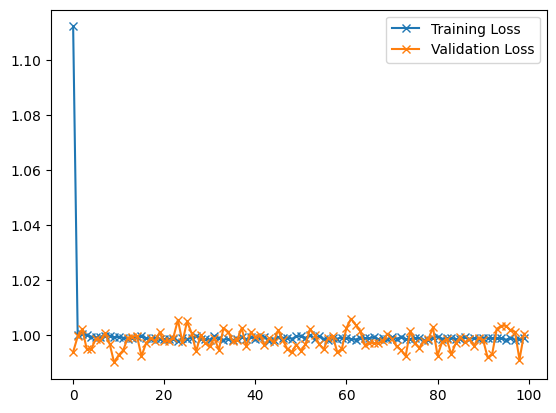

In [99]:
plt.figure()
plt.plot(trainer.train_loss, label='Training Loss', marker='x')
plt.plot(trainer.validation_loss, label='Validation Loss', marker='x')
# plt.yscale('log')
# plt.xlim([0, 10])
plt.legend()

In [100]:
print(trainer)


        Model Properties:
        PerceptronBD(
  (model): Sequential(
    (0): Linear(in_features=40, out_features=20, bias=True)
    (1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout1d(p=0.5, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=10, bias=True)
    (5): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout1d(p=0.5, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=10, out_features=5, bias=True)
    (9): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout1d(p=0.5, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=5, out_features=5, bias=True)
    (13): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Dropout1d(p=0.5, inplace=False)
    (15): ReLU()
    (16): Linear(in_features=5, out_features=2, bias=True)
    (17): BatchNorm1d(2, eps=1e-05, momentum

In [101]:
train_error, train_pred = generate_model_error_and_prediction(trainer.model, trainer.train_loader, y_columns, y_scaler)
val_error, val_pred = generate_model_error_and_prediction(trainer.model, trainer.validation_loader, y_columns, y_scaler)

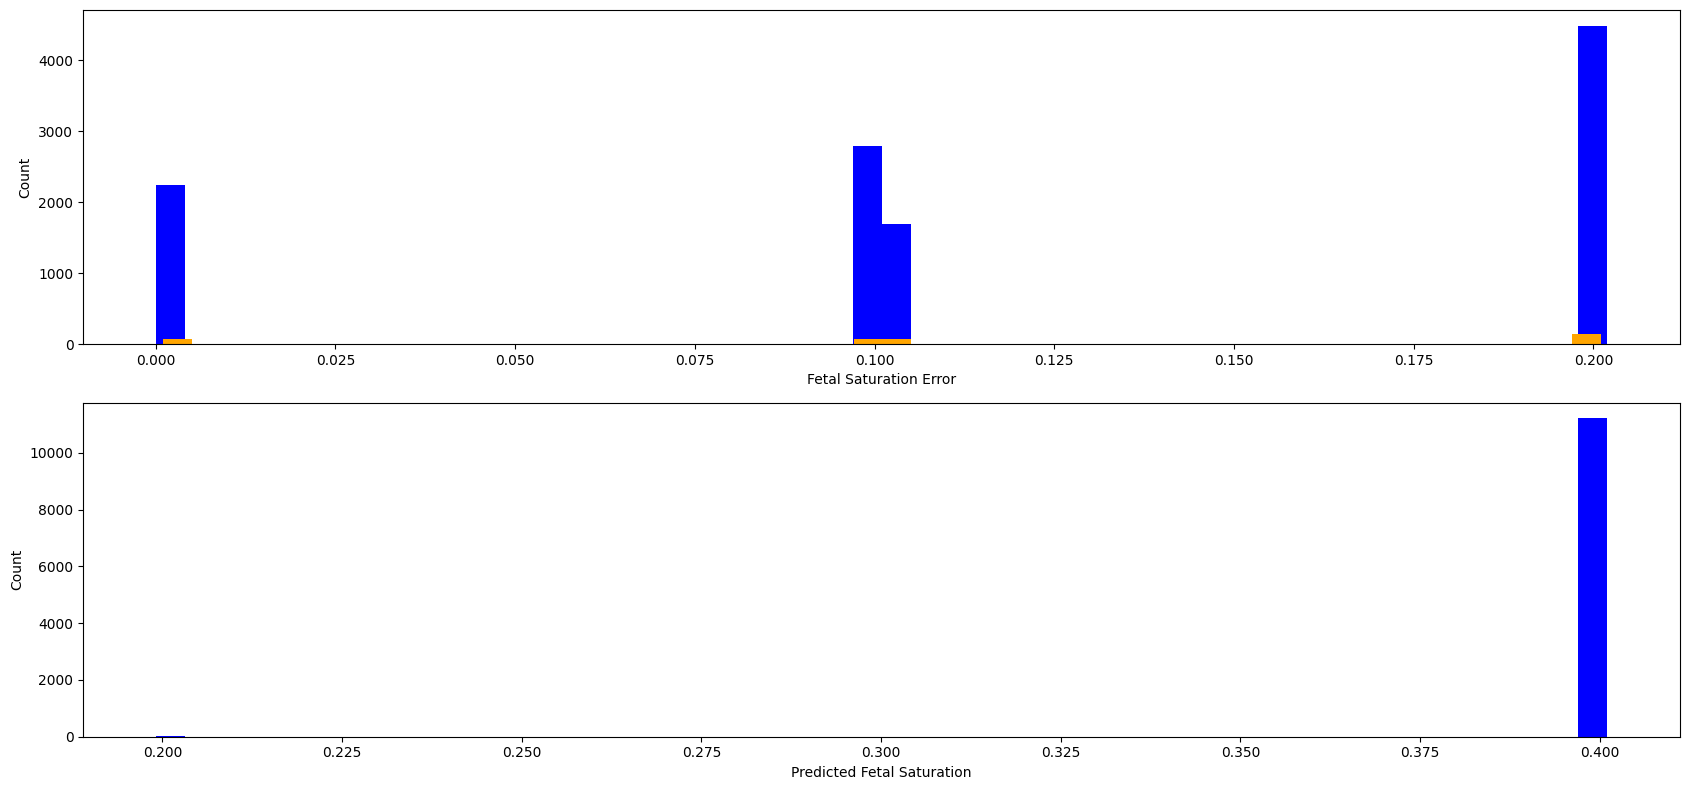

In [102]:
fig, axes = plt.subplots(2, 1, squeeze=True, figsize=(17, 8))
BIN_COUNT = 50
# Plot Errors
ax = axes[0]
plt.sca(ax)
column_name = train_error.columns[0]
plt.hist(train_error[column_name], bins=BIN_COUNT, color='blue')
plt.hist(val_error[column_name], bins=BIN_COUNT, color='orange')
plt.xlabel(column_name)
plt.ylabel('Count')

# Plot Predictions
ax = axes[1]
plt.sca(ax)
column_name = train_pred.columns[0]
plt.hist(train_pred[column_name], bins=BIN_COUNT, color='blue')
plt.hist(val_pred[column_name], bins=BIN_COUNT, color='orange')
plt.xlabel(column_name)
plt.ylabel('Count')
    
plt.tight_layout()
plt.show()

In [103]:
# Rough MSE's in percentage
print(f'Train Error(non-normalized): {trainer.train_loss[-1] * y_scaler.var_ }')
print(f'Validation Error(non-normalized): {trainer.validation_loss[-1] * y_scaler.var_ }')

Train Error(non-normalized): [0.01999643]
Validation Error(non-normalized): [0.02003153]


In [104]:
# Model Info
torchinfo.summary(trainer.model)

Layer (type:depth-idx)                   Param #
PerceptronBD                             --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       820
│    └─BatchNorm1d: 2-2                  40
│    └─Dropout1d: 2-3                    --
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       210
│    └─BatchNorm1d: 2-6                  20
│    └─Dropout1d: 2-7                    --
│    └─ReLU: 2-8                         --
│    └─Linear: 2-9                       55
│    └─BatchNorm1d: 2-10                 10
│    └─Dropout1d: 2-11                   --
│    └─ReLU: 2-12                        --
│    └─Linear: 2-13                      30
│    └─BatchNorm1d: 2-14                 10
│    └─Dropout1d: 2-15                   --
│    └─ReLU: 2-16                        --
│    └─Linear: 2-17                      12
│    └─BatchNorm1d: 2-18                 4
│    └─Dropout1d: 2-19                   --
│    └─ReLU: 2-20         

In [105]:
# model_name = 'msat_percep_irsi'
# import joblib
# # Save Model
# torch.save(model.state_dict(), rf'../models/{model_name}')
# # Save the Scalers for Later Use
# joblib.dump(x_scaler, rf'../models/{model_name}_xscaler')
# joblib.dump(y_scaler, rf'../models/{model_name}_yscaler')

In [106]:
# # Load Model Code
# model = PerceptronReLU([20, 10, 4, 2, 1])
# model.load_state_dict(torch.load(r'../models/fsat_delta_5det_v1'))
# model = model.cuda()
# x_scaler = joblib.load(rf'../models/{model_name}_xscaler')
# y_scaler = joblib.load(rf'../models/{model_name}_yscaler')